In [1]:
from tqdm.auto import tqdm
import numpy as np
import tensorflow as tf
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt
import os
import sys
from sparse_causal_model_learner_rl.learner import Learner
import gin
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.config.config import Config
from sparse_causal_model_learner_rl.trainable.decoder import IdentityDecoder
import pickle
%matplotlib inline

In [2]:
load_config_files(['../keychest/config/5x5.gin', '../sparse_causal_model_learner_rl/configs/common.gin'])

['5x5', 'common']

In [3]:
# # def get_xy(steps=1000, orig_shape=True):
# steps = 100
# orig_shape = True
# """Get the dataset."""
# gin.bind_parameter('Config.feature_shape', None)
# gin.bind_parameter('KeyChestEnvironment.flatten_observation', not orig_shape)
# gin.bind_parameter('Config.env_steps', steps)
# gin.bind_parameter('Config.decoder', None)
# gin.bind_parameter('Config.model', None)
# gin.bind_parameter('Config.reconstructor', None)
# gin.bind_parameter('Config.value_predictor', None)
# learner = Learner(Config())
# learner.collect_steps(do_tqdm=True)
# obs_x = learner._context.get('obs_x').cpu().numpy()
# obs_y = learner._context.get('obs_y').cpu().numpy()
# act_x = learner._context.get('action_x').cpu().numpy()

# a

# X = np.concatenate((obs_x, act_x), axis=1)
# y = obs_y
# return X, y

In [4]:
def get_xy_conv(steps=1000, orig_shape=True):
    """Get the dataset."""
    gin.bind_parameter('Config.feature_shape', None)
    gin.bind_parameter('KeyChestEnvironment.flatten_observation', not orig_shape)
    gin.bind_parameter('Config.env_steps', steps)
    gin.bind_parameter('Config.decoder', None)
    gin.bind_parameter('Config.model', None)
    gin.bind_parameter('Config.reconstructor', None)
    gin.bind_parameter('Config.value_predictor', None)
    gin.bind_parameter('Config.disable_cuda', True)
    learner = Learner(Config())
    learner.collect_steps(do_tqdm=True)
    obs_x = learner._context.get('obs_x').cpu().numpy()
    obs_y = learner._context.get('obs_y').cpu().numpy()
    act_x = learner._context.get('action_x').cpu().numpy()
    
    if orig_shape:
        return obs_x, act_x, obs_y
    else:
        X = np.concatenate((obs_x, act_x), axis=1)
        y = obs_y
        return X, y

In [5]:
Xo_train, Xa_train, yo_train = get_xy_conv(steps=100000, orig_shape=True)
#Xo_test, Xa_test, yo_test = get_xy_conv(steps=10000, orig_shape=True)

Make environment KeyChest-v0 None {}


# Conv model

In [6]:
from tensorflow.keras.backend import image_data_format

In [7]:
image_data_format()

'channels_last'

In [8]:
learner = Learner(Config())

Make environment KeyChest-v0 None {}


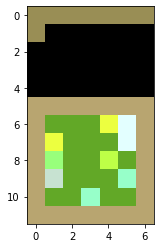

In [9]:
# using channels last format in the env as well
plt.imshow(learner.env.reset() @ np.random.rand(11, 3))
plt.show()

In [10]:
Xo_train.shape, Xa_train.shape

((91656, 12, 7, 11), (91656, 4))

In [11]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [16]:
np.random.shuffle(Xo_train)

In [17]:
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, ReLU, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.activations import tanh

# Define two input layers
image_input = Input((12, 7, 11))
vector_input = Input((4,))

# Convolution + Flatten for the image
conv_layer = image_input

conv_layer = Conv2D(512, (3, 3), padding='valid')(conv_layer)
conv_layer = MaxPooling2D()(conv_layer)
print(conv_layer.shape)
conv_layer = ReLU()(conv_layer)
# conv_layer = Conv2D(64, (5, 5), padding='same')(conv_layer)

# print(conv_layer.shape)

# conv_layer = Conv2D(1024, (2, 2))(conv_layer)
# conv_layer = MaxPooling2D((2, 2), padding='valid')(conv_layer)
# conv_layer = ReLU()(conv_layer)

flat_layer = Flatten()(conv_layer)

print(conv_layer.shape, flat_layer.shape)

# Concatenate the convolutional features and the vector input
# concat_layer = Concatenate()([vector_input, flat_layer])
concat_layer = flat_layer
middle = Dense(1024)(concat_layer)
middle = ReLU()(middle)
mean = Dense(2688)(middle)
logvar = Dense(2688)(middle)

middle = Sampling()([mean, logvar])

upsample = Reshape((12, 7, 32))(middle)

# upsample = UpSampling2D()(upsample)
# upsample = Conv2DTranspose(512, (2, 2))(upsample)
# upsample = ReLU()(upsample)

# print(upsample.shape)

# upsample = UpSampling2D((2, 2))(upsample)
# print(upsample.shape)
upsample = Conv2DTranspose(11, (3, 3), padding='same')(upsample)
# upsample = ReLU()(upsample)

# print(upsample.shape)

# define a model with a list of two inputs
model = Model(inputs=[image_input], outputs=upsample)

print(upsample.shape, image_input.shape)

(?, 5, 2, 512)
(?, 5, 2, 512) (?, 5120)
(?, 12, 7, 11) (?, 12, 7, 11)


In [18]:
assert model.predict([Xo_train[:10], Xa_train[:10]]).shape[1:] == yo_train.shape[1:]

In [19]:
model.compile('adam', 'mse')

In [20]:
# fitting on inputs...
model.fit([Xo_train, Xa_train], Xo_train, epochs=100, batch_size=128)

Train on 91656 samples
Epoch 1/100
91656/91656 [==============================] - 15s 164us/sample - loss: 0.0167
Epoch 2/100
91656/91656 [==============================] - 15s 163us/sample - loss: 0.0025
Epoch 3/100
91656/91656 [==============================] - 15s 160us/sample - loss: 8.3045e-04
Epoch 4/100
77952/91656 [========================>.....] - ETA: 2s - loss: 4.7299e-04

KeyboardInterrupt: 

In [ ]:
obs1 = model.predict([Xo_train[0:1], Xa_train[0:1]])

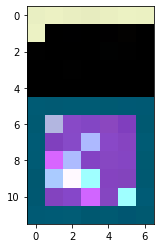

In [38]:
# using channels last format in the env as well
plt.imshow(obs1[0, :, :, :] @ np.random.rand(11, 3))
plt.show()

# FC model -- doesn't work well

In [8]:
pickle.dump([Xtrain, ytrain, Xtest, ytest], open('dataset.pkl', 'wb'))

In [3]:
Xtrain, ytrain, Xtest, ytest = pickle.load(open('dataset.pkl', 'rb'))

In [4]:
gin.bind_parameter('Config.env_steps', 10)
gin.bind_parameter('Config.disable_cuda', True)
learner = Learner(Config())

Make environment KeyChest-v0 None {}


In [5]:
env = learner.env
h, w, c = env.engine._observation.shape

In [16]:
idxes = list(range(len(Xtrain)))
np.random.shuffle(idxes)

In [19]:
# forgot to shuffle the dataset...
Xtrain = Xtrain[idxes]
ytrain = ytrain[idxes]

In [6]:
!du -s --si dataset.pkl

747M	dataset.pkl


In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(Xtrain.shape[1],), activation='tanh', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(64, activation='tanh', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(64, activation='tanh', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(2048, activation='tanh', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(2048, activation='tanh', kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(ytrain.shape[1], activation='sigmoid', kernel_initializer='glorot_normal')
])

In [99]:
model.compile('adam', 'binary_crossentropy', metrics=['mse', 'mae'])

In [100]:
model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=100)

Train on 91632 samples, validate on 9184 samples
Epoch 1/100
91632/91632 [==============================] - 49s 533us/sample - loss: 0.0187 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0097 - val_loss: 0.0074 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0039
Epoch 2/100
91632/91632 [==============================] - 50s 543us/sample - loss: 0.0041 - mean_squared_error: 9.6965e-04 - mean_absolute_error: 0.0021 - val_loss: 0.0043 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0020
Epoch 3/100
91632/91632 [==============================] - 43s 465us/sample - loss: 0.0033 - mean_squared_error: 7.8184e-04 - mean_absolute_error: 0.0015 - val_loss: 0.0039 - val_mean_squared_error: 9.1098e-04 - val_mean_absolute_error: 0.0017
Epoch 4/100
91632/91632 [==============================] - 46s 504us/sample - loss: 0.0031 - mean_squared_error: 7.3046e-04 - mean_absolute_error: 0.0014 - val_loss: 0.0039 - val_mean_squared_error: 8.9386e-04 - val_mean_absolute_e

KeyboardInterrupt: 